# Modeling spiking neural networks with Brian

In [1]:
# If Brian2 is not yet installed, the following will install it
# (otherwise it will print a number of "Requirement already satisfied" lines)
# Note that you online have to do this once, except for online notebooks like
# deepnote which start on a fresh machine each time.
!pip install brian2

Let's first import "everything" from the Brian 2 package.

This also provides access to the scientific computing package numpy (imported as np), and to the package pyplot from the plotting library matplotlib (imported as plt).

We also ask the notebook to include plots directly in the notebook (instead of showing them in a separate window). Note that lines starting with % are specific commands for the jupyter notebook, they won't work in a Python script, for example.

We also switch off Brian's "code generation" mechanism, which improves the performance for complex models by generating/compiling/executing C++ code "behind the scenes". For the simple models that we are covering in this tutorial, this is not necessary – it even slows down things due to the need for compilation.

In [2]:
from brian2 import *
prefs.codegen.target = 'numpy'

In [3]:
%matplotlib inline
%xmode minimal

Exception reporting mode: Minimal


## Physical units
Brian provides a useful system to work with physical quantities. After the above export, you can use physical units like `ms` or `mV` directly:

In [4]:
C = 100*pF
g_L = 10*nS
E_L = -70*mV
V_threshold = -50*mV
print(V_threshold - E_L)

20. mV


It automatically takes care of different scales, as well as of divisions/multiplications of quantities with different units:

In [5]:
print(10*nS + 0.1*mS)  # nano Siemens + milli Siemens
print(C/g_L)  # a capacitance divided by a conductance results in a time

100.01 uS
10. ms


Adding quantities of different units will lead to an error:

In [6]:
10*nS + 10*ms

DimensionMismatchError: Cannot calculate 10. nS + 10. ms, units do not match (units are siemens and second).

## Neurons

Let's create a group of 3 integrate-and-fire neurons. The equation is the same as in the lecture 2 weeks ago:
in the absence of a stimulus, the membrane potential relaxes back to the resting potential `E_L`. In this
model, `I_stim` is part of the model equations to state that its value is different for each neuron (the constants like
`C` or `g_L` defined outside the equations are the same for all neurons). The `threshold` arguments gives a condition
that triggers a spike, and the `reset` argument describes a statement that should be executed for each spike.

In [7]:
start_scope()
N = 3
E_L = -70*mV
V_threshold = -50*mV
C = 100*pF
g_L = 10*nS
tau = C/g_L
sigma_noise = 10*mV
neurons = NeuronGroup(N, '''dV/dt = (g_L*(E_L-V) + I_stim)/C: volt
                            I_stim : amp (constant)''',
                      threshold='V>V_threshold', reset='V=E_L', method='euler')
# Initialize values
neurons.V = '(V_threshold - E_L)*0.5*rand() + E_L'
# The stimulus is now between 0.2nA and 0.8nA
neurons.I_stim = [0.2, 0.5, 0.8]*nA

# record membrane potential and spikes (record=True is a shorthand for "record all neurons")
v_mon = StateMonitor(neurons, 'V', record=True)
spike_mon = SpikeMonitor(neurons)

# run simulation
run(100*ms)

The "monitors" that we created above have attributes storing the values they recorded. The `SpikeMonitor` `spike_mon` provides the attributes:

* `t` : 1-d array of spike times
* `i` : 1-d array of indices of the neurons that spiked
(these two arrays always have the same length and the entries correspond to each other)
* `count` : 1-d array with the total spike count of each neuron

The `StateMonitor` `v_mon` has the attributes:
* `t` : 1-d array of the time points where values were recorded (by default every 0.1ms)
* `V` (name of the recorded variable) : A 2-d array (number of neurons × number of time points) with all the values

To access the values for a single neuron you can use e.g. `v_mon.V[0]`, or you can plot all lines at the same time
by providing a transposed matrix to matplotlib with `v_mon.V.T`.

We could plot things directly by calling `plt.plot`, but by calling `plt.subplots` first we can easily arrange things in subplots.

[ 0 20 34]


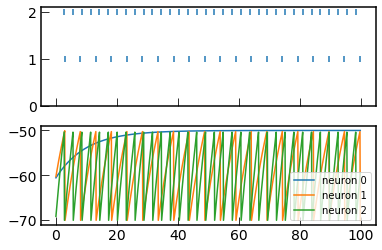

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(spike_mon.t/ms, spike_mon.i, '|')
ax[0].set_ylim(0, 2.1)
ax[1].plot(v_mon.t/ms, v_mon.V[0]/mV, label='neuron 0');
ax[1].plot(v_mon.t/ms, v_mon.V[1]/mV, label='neuron 1');
ax[1].plot(v_mon.t/ms, v_mon.V[2]/mV, label='neuron 2');
# To plot all lines with a single command (but without labels), use
# ax[1].plot(v_mon.t/ms, v_mon.V.T/mV,);
ax[1].legend()
print(spike_mon.count[:])

Above, the neuron with the weakest input never spikes, and the other neurons spike regularly with a frequency that depends on the strength of the current.
Often, we would like to add some random noise to the membrane potential to account for general biological noise and background activity that we do not want
to model in detail. For this, we can add a noise term (`xi` is a builtin variable provided by Brian) –– ignore the `tau**-0.5`, we need this for correct dimensions of the noise term because of the way it scales with time.

In [9]:
start_scope()
N = 3
E_L = -70*mV
V_threshold = -50*mV
C = 100*pF
g_L = 10*nS
tau = C/g_L
sigma_noise = 10*mV
neurons = NeuronGroup(N, '''dV/dt = (g_L*(E_L-V) + I_stim)/C + sigma_noise*xi*tau**-0.5 : volt  # now with noise term
                            I_stim : amp (constant)''',
                      threshold='V>V_threshold', reset='V=E_L', method='euler')
# Initialize values
neurons.V = '(V_threshold - E_L)*0.5*rand() + E_L'
# The stimulus is now between 0.2nA and 0.8nA
neurons.I_stim = [0.2, 0.5, 0.8]*nA

# record membrane potential and spikes (record=True is a shorthand for "record all neurons")
v_mon = StateMonitor(neurons, 'V', record=True)
spike_mon = SpikeMonitor(neurons)

# run simulation
run(100*ms)

[ 9 16 33]


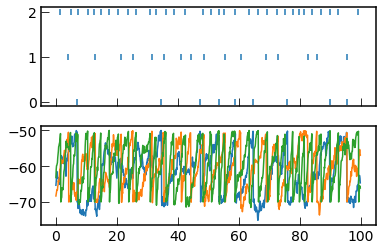

In [10]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(spike_mon.t/ms, spike_mon.i, '|')
ax[1].plot(v_mon.t/ms, v_mon.V.T/mV,);
print(spike_mon.count[:])

Typically, neurons in sensory cortices are described as having a "preferred stimulus feature", e.g. cells in the primary visual cortex are often direction selective and have a preferred direction.
For example, a cell might become very active if a stimulus moving upwards (direction 0) is shown in its visual field, only show weak activity for stimuli moving to the right (direction $\pi$) or to the left (direction $-\pi$), and show no activity at all for a stimulus moving down (direction $\pi$).
Let us model this in the simplest way possible by creating a population of neurons where each neuron has its preferred direction $\Theta$ (`theta`), and where the input current strength is a Gaussian function of the difference between the presented stimulus ($\Theta_\mathrm{stim}$) and the preferred stimulus of each cell. Note that for simplicity, the code does not take care of the periodic nature of the stimulus, i.e. that $-\pi$ is the same direction as $\pi$.

In [11]:
start_scope()
tau = 10*ms
sigma_noise = 10*mV
theta_stim = -pi/2    # stimulus
sigma_stim = pi/8  # stimulation width
amp_stim = 0.4*nA      # stimulus amplitude
N = 400
neurons = NeuronGroup(N, '''dV/dt = (g_L*(E_L-V) + I_stim)/C + sigma_noise*xi*tau**-0.5: volt
                            I_stim = amp_stim*exp(-(theta - theta_stim)**2/(2*sigma_stim)**2) : amp
                            theta : 1 (constant)''',
                      threshold='V>V_threshold', reset='V=E_L', method='euler')
# Initialize values
neurons.V = '(V_threshold - E_L)*0.5*rand() + E_L'
neurons.theta = '-pi + 2*pi*i/N'

# record spikes
spike_mon = SpikeMonitor(neurons)

# run simulation
run(100*ms)

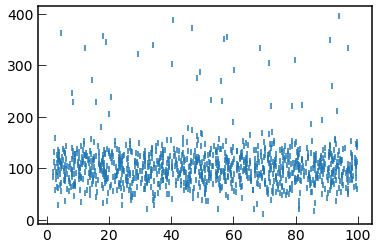

In [12]:
fig, ax = plt.subplots()
ax.plot(spike_mon.t/ms, spike_mon.i, '|');
# TODO: How could we show the preferred direction on the y axis (instead of the neuron index)
# TODO: How could we plot a "population tuning curve" (number of spikes over preferred stimulus)?

## Synapses
Let us know connect our neurons with synapses. For now, the synapses are connected in a uniform fashion amongst each other.
To create synapses, we have to

1. create a `Synapses` object that states:
    * which populations of neurons should be connected with each other (here: `exc_neurons` to themselves)
    * what properties are unique to each synapse (here: each synapse has its own strength, also called "synaptic weight", $w$)
    * what should happen if the presynaptic cell spikes (`on_pre`, here: increase the post-synaptic current `I_ee` by `w`)
2. Which neurons in the populations should be connected. Here, we are randomly connecting any neurons with a probability of 50% (`p=0.5`)

In [13]:
start_scope()
tau = 10*ms
sigma_noise = 10*mV
theta_stim = 0.; sigma_stim = pi/8; amp_stim = 0.4*nA  # stimulus parameters
tau_e = 50*ms
N_E = 400

# excitatory neurons
exc_neurons = NeuronGroup(N_E, '''dV/dt = (g_L*(E_L-V) + I_stim + I_ee)/C + sigma_noise*xi*tau**-0.5: volt
                                  dI_ee/dt = -I_ee/tau_e : amp
                                  I_stim = amp_stim*exp(-(theta - theta_stim)**2/(2*sigma_stim)**2) : amp
                                  theta : 1 (constant)''',
                          threshold='V>V_threshold', reset='V=E_L', method='euler')
exc_neurons.V = '(V_threshold - E_L)*0.5*rand() + E_L'
exc_neurons.theta = '-pi + 2*pi*i/N_E'

# recurrent excitatory synapses
E_to_E = Synapses(exc_neurons, exc_neurons,
                  'w: amp', on_pre='I_ee += w')
E_to_E.connect(p=0.5)
E_to_E.w = '40*pA/N_E'

# Monitor neurons
exc_mon = SpikeMonitor(exc_neurons)

# run simulation
run(1000*ms)
amp_stim = 0*nA  # switch off stimulus
run(1000*ms)
# TODO: Can we get sustained activity by increasing the weight?

TypeError: Cannot create a consistent method resolution
order (MRO) for bases BrianObjectException, BrianObjectException

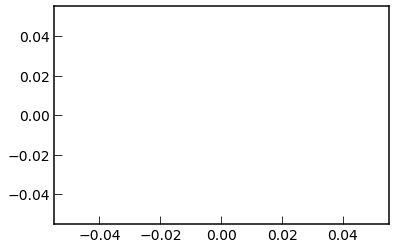

In [14]:
fig, ax = plt.subplots()
ax.plot(exc_mon.t/ms, exc_mon.i, '|');

<div align='center' style='font-weight: bold;'>We did not covert the part below in the tutorial, but please check it out if you are interested!</div>

---

## Full model
Cells in the brain are usually not connected together randomly. In the visual cortex, for example, cells will connect more likely (or more strongly) to cells that have a similar stimulus preference.
We can model this by not assigning the same synaptic weight `w` to all synapses, but to make the synaptic weight depend on the difference between the stimulus preferences of the two cells.
Here, we use this in the `E_to_E.w = ...` line, by making the weight a function of `theta_pre` and `theta_post`, the preferred stimulus of the pre- and post-synaptic
cell, respectively. Again, for simplicity we do not deal with the fact that a preference close to $-\pi$ is actually very similar to a preference close to $\pi$.

We also add an inhibitory population of neurons which are not activated by the external stimulus, but only from the excitatory population.
The inhibitory cells are connected unspecifically to the excitatory cells.

The example uses a lot more code now, but all the components are very similar to what we have used before. Our network is now a (crude) model of working memory circuits in the brain: a stimulus will drive the network into a state that sustains the activity for a while after the stimulus is switched off.

In [26]:
start_scope()
tau = 10*ms
sigma_noise = 10*mV
theta_stim = 0; sigma_stim = pi/8; amp_stim = 0.4*nA  # stimulus parameters
tau_e = 50*ms; tau_i = 5*ms
N_E = 400; N_I = 100

# excitatory neurons
exc_neurons = NeuronGroup(N_E, '''dV/dt = (g_L*(E_L-V) + I_ee + I_ei + I_stim)/C + sigma_noise*xi*tau**-0.5: volt
                                  dI_ee/dt = -I_ee/tau_e : amp
                                  dI_ei/dt = -I_ei/tau_i : amp
                                  I_stim = amp_stim*exp(-(theta - theta_stim)**2/(2*sigma_stim)**2) : amp
                                  theta : 1 (constant)''',
                          threshold='V>V_threshold', reset='V=E_L', method='euler')
exc_neurons.V = '(V_threshold - E_L)*0.5*rand() + E_L'
exc_neurons.theta = '-pi + 2*pi*i/N_E'

# recurrent excitatory synapses
E_to_E = Synapses(exc_neurons, exc_neurons, 'w: amp', on_pre='I_ee += w')
E_to_E.connect(p=0.5)
sigma_struct = pi/8
J_global = 0.085*pA; J_selective = 3.15*pA
# The connection strength depends on the difference in stimulus preference
E_to_E.w = 'J_global + J_selective*exp(-(theta_pre - theta_post)**2/(2*sigma_stim)**2)'

# inhibitory neurons
inh_neurons = NeuronGroup(N_I, '''dV/dt = (g_L*(E_L-V) + I_ie + I_ii)/C + sigma_noise*xi*tau**-0.5: volt
                                  dI_ie/dt = -I_ie/tau_e : amp
                                  dI_ii/dt = -I_ii/tau_i : amp''',
                          threshold='V>V_threshold', reset='V=E_L', method='euler')
inh_neurons.V = '(V_threshold - E_L)*0.5*rand() + E_L'

# remaining recurrent synapses
w_ei = 5*nA/N_I; w_ie = 0.2*nA/N_E; w_ii = 0.2*nA/N_I
I_to_I = Synapses(inh_neurons, inh_neurons, on_pre='I_ii -= w_ii')
I_to_I.connect(p=0.5)

I_to_E = Synapses(inh_neurons, exc_neurons, on_pre='I_ei -= w_ei')
I_to_E.connect(p=0.5)

E_to_I = Synapses(exc_neurons, inh_neurons, on_pre='I_ie += w_ie')
E_to_I.connect(p=0.5)

# Monitor all neurons
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)

# run the simulation (since the simulation takes a bit longer now, we add
# report='text' to get some output during the run)
run(500*ms, report='text')
amp_stim = 0*nA
run(2500*ms, report='text')

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 2s
Starting simulation at t=0.5 s for a duration of 2.5 s
2.0641 s (82%) simulated in 10s, estimated 2s remaining.
2.5 s (100%) simulated in 12s


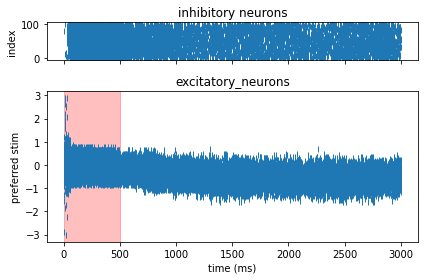

In [27]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 4]}, sharex=True)
ax[0].plot(inh_mon.t/ms, inh_mon.i, '|');
ax[0].set(title='inhibitory neurons', ylabel='index')
ax[1].plot(exc_mon.t/ms, exc_neurons.theta[exc_mon.i], '|');
ax[1].set(title='excitatory_neurons', ylabel='preferred stim', xlabel='time (ms)')
# show the period where the stimulus is active
ax[1].axvspan(0, 500, color='red', alpha=0.25)
fig.tight_layout()

As you can see in the above plot, the neurons sustain the activity after the stimulus (red rectangle) is switched off. Note that there is randomness in the simulation, so the details, e.g. how long the activity is sustained, can change between runs.
Also note that the neural representation typically shifts a bit during the time where the stimulus is no longer present, due to the noise in the system.
This so-called "drift" is a typical observation in such systems.